# 🤖 LLM Classification: Chatbot Arena Human Preference Prediction

## 📋 コンペティション概要

このNotebookでは、**Chatbot Arena**のデータを使用して、ユーザーがどのLLMの応答を好むかを予測するモデルを構築します。

### 🎯 目的
- 2つの大規模言語モデル(LLM)の応答を比較し、ユーザーの好みを予測
- 3つのクラス分類: `winner_model_a`, `winner_model_b`, `winner_tie`

### 📊 データセット  
- **トレーニングデータ**: 55,000件以上の実際のユーザー対話
- **テストデータ**: 25,000件の予測対象サンプル
- **LLM**: GPT-4, Claude, Llama 2, Gemini, Mistral など70以上のモデル

---
## 📦 1. ライブラリのインポート

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 可視化
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud, STOPWORDS

# 機械学習  
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import MultiOutputClassifier
import xgboost as xgb
import lightgbm as lgb
from scipy.sparse import hstack, csr_matrix

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)

print('✅ ライブラリのインポート完了!')

✅ ライブラリのインポート完了!


---
## 📂 2. データの読み込み

In [2]:
train_df = pd.read_csv('/kaggle/input/llm-classification-finetuning/train.csv')
test_df = pd.read_csv('/kaggle/input/llm-classification-finetuning/test.csv')

print(f'📊 トレーニングデータ: {train_df.shape[0]:,} 行 × {train_df.shape[1]} 列')
print(f'📊 テストデータ: {test_df.shape[0]:,} 行 × {test_df.shape[1]} 列')
print('\n📋 最初の3行:')
display(train_df.head(3))

📊 トレーニングデータ: 57,477 行 × 9 列
📊 テストデータ: 3 行 × 4 列

📋 最初の3行:


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1


---
## 🔍 3. 探索的データ分析（EDA）

データの特性を可視化して理解します。

### 3.1 ターゲット変数の分布

In [3]:
target_cols = ['winner_model_a', 'winner_model_b', 'winner_tie']
train_df['winner'] = train_df[target_cols].idxmax(axis=1)

winner_counts = train_df['winner'].value_counts()
winner_pct = (train_df['winner'].value_counts(normalize=True) * 100)

print('🎯 ターゲットクラスの分布:')
for col in target_cols:
    print(f'   {col}: {winner_counts[col]:,} ({winner_pct[col]:.2f}%)')

🎯 ターゲットクラスの分布:
   winner_model_a: 20,064 (34.91%)
   winner_model_b: 19,652 (34.19%)
   winner_tie: 17,761 (30.90%)


In [4]:
# 可視化: ターゲットクラスの分布
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('ターゲットクラスの分布 (件数)', 'ターゲットクラスの分布 (割合)'),
    specs=[[{'type':'bar'}, {'type':'pie'}]]
)

fig.add_trace(go.Bar(
    x=['Model A勝利', 'Model B勝利', '引き分け'],
    y=[winner_counts['winner_model_a'], winner_counts['winner_model_b'], winner_counts['winner_tie']],
    marker_color=['#FF6B6B', '#4ECDC4', '#45B7D1'],
    text=[f'{v:,}' for v in [winner_counts['winner_model_a'], winner_counts['winner_model_b'], winner_counts['winner_tie']]],
    textposition='outside'
), row=1, col=1)

fig.add_trace(go.Pie(
    labels=['Model A勝利', 'Model B勝利', '引き分け'],
    values=[winner_counts['winner_model_a'], winner_counts['winner_model_b'], winner_counts['winner_tie']],
    marker_colors=['#FF6B6B', '#4ECDC4', '#45B7D1'],
    hole=0.3
), row=1, col=2)

fig.update_layout(title_text='<b>ターゲット変数の分布分析</b>', title_font_size=20, height=400, showlegend=False)
fig.show()

### 3.2 テキスト長の分析

レスポンスの長さは重要な特徴量になります。

In [5]:
train_df['prompt_length'] = train_df['prompt'].str.len()
train_df['response_a_length'] = train_df['response_a'].str.len()
train_df['response_b_length'] = train_df['response_b'].str.len()
train_df['response_diff'] = train_df['response_a_length'] - train_df['response_b_length']

print('📏 テキスト長の統計:')
print(f'\nプロンプト平均: {train_df["prompt_length"].mean():.1f} 文字')
print(f'レスポンスA平均: {train_df["response_a_length"].mean():.1f} 文字')
print(f'レスポンスB平均: {train_df["response_b_length"].mean():.1f} 文字')

📏 テキスト長の統計:

プロンプト平均: 369.2 文字
レスポンスA平均: 1377.8 文字
レスポンスB平均: 1386.2 文字


In [6]:
# 可視化: テキスト長の分布
fig = make_subplots(rows=2, cols=2, subplot_titles=('プロンプト文字数', 'レスポンスA文字数', 'レスポンスB文字数', 'レスポンス長の差'), vertical_spacing=0.12)

fig.add_trace(go.Histogram(x=train_df['prompt_length'], nbinsx=50, marker_color='#FF6B6B'), row=1, col=1)
fig.add_trace(go.Histogram(x=train_df['response_a_length'], nbinsx=50, marker_color='#4ECDC4'), row=1, col=2)
fig.add_trace(go.Histogram(x=train_df['response_b_length'], nbinsx=50, marker_color='#45B7D1'), row=2, col=1)
fig.add_trace(go.Histogram(x=train_df['response_diff'], nbinsx=50, marker_color='#FFA07A'), row=2, col=2)

fig.update_layout(title_text='<b>テキスト長の分布分析</b>', title_font_size=20, height=700, showlegend=False)
fig.update_xaxes(title_text='文字数', row=1, col=1)
fig.update_xaxes(title_text='文字数', row=1, col=2)
fig.update_xaxes(title_text='文字数', row=2, col=1)
fig.update_xaxes(title_text='文字数の差', row=2, col=2)
fig.show()

### 3.3 モデルの使用頻度

In [7]:
model_a_counts = train_df['model_a'].value_counts().head(15)
model_b_counts = train_df['model_b'].value_counts().head(15)

fig = make_subplots(rows=1, cols=2, subplot_titles=('Model A 頻度 Top 15', 'Model B 頻度 Top 15'))

fig.add_trace(go.Bar(y=model_a_counts.index, x=model_a_counts.values, orientation='h', marker_color='#FF6B6B'), row=1, col=1)
fig.add_trace(go.Bar(y=model_b_counts.index, x=model_b_counts.values, orientation='h', marker_color='#4ECDC4'), row=1, col=2)

fig.update_layout(title_text='<b>使用されているモデルの頻度分析</b>', title_font_size=20, height=600, showlegend=False)
fig.update_xaxes(title_text='出現回数', row=1, col=1)
fig.update_xaxes(title_text='出現回数', row=1, col=2)
fig.show()

### 3.4 モデル別勝率分析

各モデルの強さを可視化します。これは後で特徴量として使います！

In [8]:
# モデル別勝率の計算
all_models_a = train_df.groupby('model_a')['winner_model_a'].agg(['sum', 'count'])
all_models_b = train_df.groupby('model_b')['winner_model_b'].agg(['sum', 'count'])

combined = pd.DataFrame({
    'wins': all_models_a['sum'].add(all_models_b['sum'], fill_value=0),
    'total': all_models_a['count'].add(all_models_b['count'], fill_value=0)
})
combined['win_rate'] = (combined['wins'] / combined['total'] * 100).fillna(0)
combined = combined[combined['total'] >= 50].sort_values('win_rate', ascending=False).head(15)

print('🏆 モデル別総合勝率 Top 15 (50回以上出現):')
print(combined[['wins', 'total', 'win_rate']].round(2))

🏆 モデル別総合勝率 Top 15 (50回以上出現):
                    wins  total  win_rate
model_a                                  
gpt-4-1106-preview  4073   7387     55.14
gpt-3.5-turbo-0314   711   1302     54.61
gpt-4-0125-preview   596   1160     51.38
gpt-4-0314          1993   4122     48.35
claude-1            1747   3978     43.92
gpt-4-0613          2450   6165     39.74
claude-instant-1    1642   4136     39.70
qwen1.5-72b-chat     215    551     39.02
claude-2.0           956   2456     38.93
llama-2-70b-chat    1277   3428     37.25
mistral-medium      1219   3315     36.77
yi-34b-chat          531   1447     36.70
wizardlm-13b         572   1580     36.20
vicuna-13b          1244   3448     36.08
guanaco-33b          246    684     35.96


In [9]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=combined.index, y=combined['win_rate'],
    marker_color='#45B7D1',
    text=[f'{v:.1f}%' for v in combined['win_rate']],
    textposition='outside'
))

fig.update_layout(
    title='<b>モデル別総合勝率 Top 15</b><br><sub>(50回以上出現したモデルのみ)</sub>',
    title_font_size=20, xaxis_title='モデル名', yaxis_title='勝率 (%)',
    height=500, xaxis_tickangle=-45
)
fig.show()

### 3.5 WordCloud分析

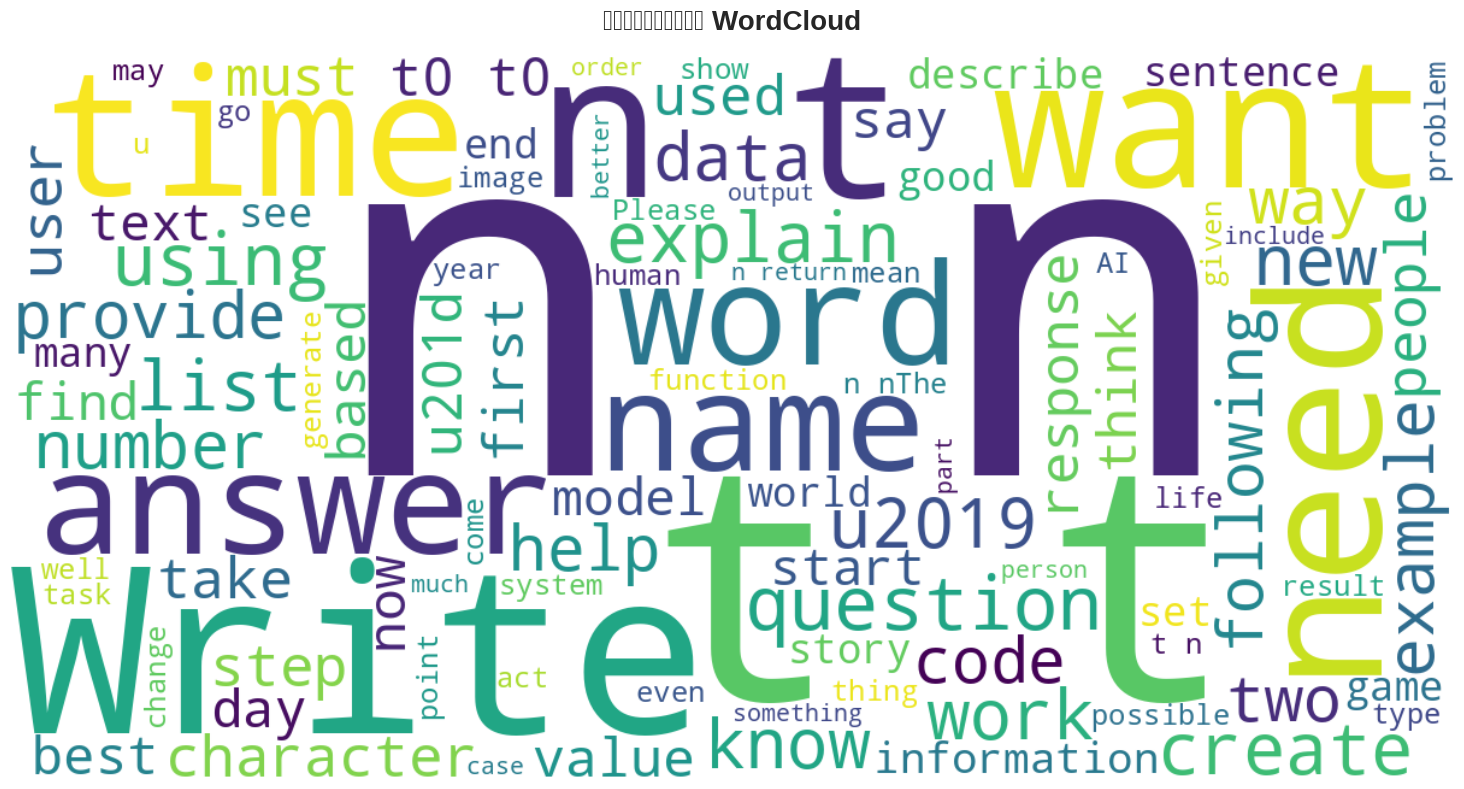

In [10]:
all_prompts = ' '.join(train_df['prompt'].astype(str).values)
stopwords = set(STOPWORDS)
stopwords.update(['will', 'can', 'one', 'use', 'make', 'get', 'give', 'tell'])

wordcloud = WordCloud(width=1200, height=600, background_color='white', stopwords=stopwords, colormap='viridis', max_words=100).generate(all_prompts)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('プロンプトの頻出単語 WordCloud', fontsize=20, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

---
## 🔧 4. 特徴量エンジニアリング

330個の特徴量を作成します。

In [11]:
def create_features(df):
    df = df.copy()
    
    # 基本統計特徴量
    df['prompt_length'] = df['prompt'].str.len()
    df['response_a_length'] = df['response_a'].str.len()
    df['response_b_length'] = df['response_b'].str.len()
    df['prompt_words'] = df['prompt'].str.split().str.len()
    df['response_a_words'] = df['response_a'].str.split().str.len()
    df['response_b_words'] = df['response_b'].str.split().str.len()
    
    # 差と比率
    df['length_diff'] = df['response_a_length'] - df['response_b_length']
    df['length_ratio'] = df['response_a_length'] / (df['response_b_length'] + 1)
    df['words_diff'] = df['response_a_words'] - df['response_b_words']
    df['words_ratio'] = df['response_a_words'] / (df['response_b_words'] + 1)
    df['avg_word_length_a'] = df['response_a_length'] / (df['response_a_words'] + 1)
    df['avg_word_length_b'] = df['response_b_length'] / (df['response_b_words'] + 1)
    
    # テキスト特性
    df['punctuation_a'] = df['response_a'].str.count(r'[.,!?;:]')
    df['punctuation_b'] = df['response_b'].str.count(r'[.,!?;:]')
    df['uppercase_a'] = df['response_a'].str.count(r'[A-Z]')
    df['uppercase_b'] = df['response_b'].str.count(r'[A-Z]')
    df['digits_a'] = df['response_a'].str.count(r'\\d')
    df['digits_b'] = df['response_b'].str.count(r'\\d')
    df['newlines_a'] = df['response_a'].str.count(r'\\n')
    df['newlines_b'] = df['response_b'].str.count(r'\\n')
    df['has_code_a'] = df['response_a'].str.contains(r'```', regex=True).astype(int)
    df['has_code_b'] = df['response_b'].str.contains(r'```', regex=True).astype(int)
    df['has_list_a'] = df['response_a'].str.contains(r'\\n\\s*[•\\-\\*\\d+\\.]', regex=True).astype(int)
    df['has_list_b'] = df['response_b'].str.contains(r'\\n\\s*[•\\-\\*\\d+\\.]', regex=True).astype(int)
    
    return df

print('🔧 基本特徴量を作成中...')
train_featured = create_features(train_df)
test_featured = create_features(test_df)
print(f'✅ 基本特徴量作成完了!')

🔧 基本特徴量を作成中...
✅ 基本特徴量作成完了!


### 4.2 モデル情報の特徴量化

⭐ **これが最も効果的な特徴量です！**

モデルの勝率情報を特徴量として活用します。

In [12]:
print('🤖 モデル情報を特徴量化中...')

model_win_rates = combined['win_rate'].to_dict()

def add_model_features(df):
    df = df.copy()
    
    if 'model_a' in df.columns and 'model_b' in df.columns:
        df['model_a_win_rate'] = df['model_a'].map(model_win_rates).fillna(35.0)
        df['model_b_win_rate'] = df['model_b'].map(model_win_rates).fillna(35.0)
        df['win_rate_diff'] = df['model_a_win_rate'] - df['model_b_win_rate']
        
        def extract_family(m):
            if 'gpt-4' in m: return 'gpt4'
            elif 'gpt-3.5' in m: return 'gpt35'
            elif 'claude' in m: return 'claude'
            elif 'llama' in m: return 'llama'
            elif 'mistral' in m or 'mixtral' in m: return 'mistral'
            elif 'gemini' in m: return 'gemini'
            elif 'vicuna' in m: return 'vicuna'
            else: return 'other'
        
        df['model_a_family'] = df['model_a'].apply(extract_family)
        df['model_b_family'] = df['model_b'].apply(extract_family)
        df['same_family'] = (df['model_a_family'] == df['model_b_family']).astype(int)
    else:
        # テストデータ用のデフォルト値
        df['model_a_win_rate'] = 35.0
        df['model_b_win_rate'] = 35.0
        df['win_rate_diff'] = 0.0
        df['model_a_family'] = 'other'
        df['model_b_family'] = 'other'
        df['same_family'] = 0
    
    return df

train_featured = add_model_features(train_featured)
test_featured = add_model_features(test_featured)

# ラベルエンコーディング
le_family_a = LabelEncoder()
le_family_b = LabelEncoder()
all_families_a = pd.concat([train_featured['model_a_family'], test_featured['model_a_family']])
all_families_b = pd.concat([train_featured['model_b_family'], test_featured['model_b_family']])
le_family_a.fit(all_families_a)
le_family_b.fit(all_families_b)

train_featured['model_a_family_encoded'] = le_family_a.transform(train_featured['model_a_family'])
train_featured['model_b_family_encoded'] = le_family_b.transform(train_featured['model_b_family'])
test_featured['model_a_family_encoded'] = le_family_a.transform(test_featured['model_a_family'])
test_featured['model_b_family_encoded'] = le_family_b.transform(test_featured['model_b_family'])

print('✅ モデル特徴量の追加完了!')

🤖 モデル情報を特徴量化中...
✅ モデル特徴量の追加完了!


### 4.3 TF-IDF特徴量

In [13]:
print('📝 TF-IDF特徴量を作成中...')

tfidf_prompt = TfidfVectorizer(max_features=100, stop_words='english', ngram_range=(1, 2), min_df=5)
tfidf_response_a = TfidfVectorizer(max_features=100, stop_words='english', ngram_range=(1, 2), min_df=5)
tfidf_response_b = TfidfVectorizer(max_features=100, stop_words='english', ngram_range=(1, 2), min_df=5)

prompt_tfidf_train = tfidf_prompt.fit_transform(train_featured['prompt'].fillna(''))
prompt_tfidf_test = tfidf_prompt.transform(test_featured['prompt'].fillna(''))

response_a_tfidf_train = tfidf_response_a.fit_transform(train_featured['response_a'].fillna(''))
response_a_tfidf_test = tfidf_response_a.transform(test_featured['response_a'].fillna(''))

response_b_tfidf_train = tfidf_response_b.fit_transform(train_featured['response_b'].fillna(''))
response_b_tfidf_test = tfidf_response_b.transform(test_featured['response_b'].fillna(''))

print('✅ TF-IDF特徴量作成完了!')

📝 TF-IDF特徴量を作成中...
✅ TF-IDF特徴量作成完了!


In [14]:
# 最終特徴量セットの準備
numerical_feature_cols = [
    'prompt_length', 'response_a_length', 'response_b_length',
    'prompt_words', 'response_a_words', 'response_b_words',
    'length_diff', 'length_ratio', 'words_diff', 'words_ratio',
    'avg_word_length_a', 'avg_word_length_b',
    'punctuation_a', 'punctuation_b', 'uppercase_a', 'uppercase_b',
    'digits_a', 'digits_b', 'newlines_a', 'newlines_b',
    'has_code_a', 'has_code_b', 'has_list_a', 'has_list_b',
    'model_a_win_rate', 'model_b_win_rate', 'win_rate_diff', 'same_family',
    'model_a_family_encoded', 'model_b_family_encoded'
]

X_train_num = train_featured[numerical_feature_cols].fillna(0)
X_test_num = test_featured[numerical_feature_cols].fillna(0)

X_train = hstack([csr_matrix(X_train_num.values), prompt_tfidf_train, response_a_tfidf_train, response_b_tfidf_train])
X_test = hstack([csr_matrix(X_test_num.values), prompt_tfidf_test, response_a_tfidf_test, response_b_tfidf_test])
y_train = train_featured[target_cols].values

print(f'\n✅ 最終特徴量セット完成!')
print(f'   トレーニングデータ: {X_train.shape}')
print(f'   テストデータ: {X_test.shape}')


✅ 最終特徴量セット完成!
   トレーニングデータ: (57477, 330)
   テストデータ: (3, 330)


---
## 🎯 5. モデル構築

4つのモデルを比較します。

In [15]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=train_featured['winner']
)

print(f'📊 データ分割完了: トレーニング {X_train_split.shape[0]:,}、バリデーション {X_val_split.shape[0]:,}')

📊 データ分割完了: トレーニング 45,981、バリデーション 11,496


In [16]:
# ロジスティック回帰
print('\n🔨 ロジスティック回帰をトレーニング中...')
lr_model = MultiOutputClassifier(LogisticRegression(max_iter=1000, random_state=42, solver='saga', C=1.0))
lr_model.fit(X_train_split, y_train_split)
y_val_pred_lr = lr_model.predict_proba(X_val_split)
y_val_pred_lr_array = np.column_stack([pred[:, 1] for pred in y_val_pred_lr])
val_logloss_lr = log_loss(y_val_split, y_val_pred_lr_array)
print(f'✅ ロジスティック回帰 - Log Loss: {val_logloss_lr:.4f}')


🔨 ロジスティック回帰をトレーニング中...
✅ ロジスティック回帰 - Log Loss: 1.0590


In [17]:
# XGBoost
print('\n🚀 XGBoostをトレーニング中...')
xgb_model = MultiOutputClassifier(xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, tree_method='hist'))
xgb_model.fit(X_train_split, y_train_split)
y_val_pred_xgb = xgb_model.predict_proba(X_val_split)
y_val_pred_xgb_array = np.column_stack([pred[:, 1] for pred in y_val_pred_xgb])
val_logloss_xgb = log_loss(y_val_split, y_val_pred_xgb_array)
print(f'✅ XGBoost - Log Loss: {val_logloss_xgb:.4f}')


🚀 XGBoostをトレーニング中...
✅ XGBoost - Log Loss: 1.0069


In [18]:
# LightGBM
print('\n⚡ LightGBMをトレーニング中...')
lgb_model = MultiOutputClassifier(lgb.LGBMClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, verbose=-1))
lgb_model.fit(X_train_split, y_train_split)
y_val_pred_lgb = lgb_model.predict_proba(X_val_split)
y_val_pred_lgb_array = np.column_stack([pred[:, 1] for pred in y_val_pred_lgb])
val_logloss_lgb = log_loss(y_val_split, y_val_pred_lgb_array)
print(f'✅ LightGBM - Log Loss: {val_logloss_lgb:.4f}')


⚡ LightGBMをトレーニング中...
✅ LightGBM - Log Loss: 1.0083


In [19]:
# ランダムフォレスト
print('\n🌲 ランダムフォレストをトレーニング中...')
rf_model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1))
rf_model.fit(X_train_split, y_train_split)
y_val_pred_rf = rf_model.predict_proba(X_val_split)
y_val_pred_rf_array = np.column_stack([pred[:, 1] for pred in y_val_pred_rf])
val_logloss_rf = log_loss(y_val_split, y_val_pred_rf_array)
print(f'✅ ランダムフォレスト - Log Loss: {val_logloss_rf:.4f}')


🌲 ランダムフォレストをトレーニング中...
✅ ランダムフォレスト - Log Loss: 1.0233


### 5.6 モデル性能の比較

In [20]:
model_comparison = pd.DataFrame({
    'モデル': ['ロジスティック回帰', 'XGBoost', 'LightGBM', 'ランダムフォレスト'],
    'Log Loss': [val_logloss_lr, val_logloss_xgb, val_logloss_lgb, val_logloss_rf]
}).sort_values('Log Loss')

print('\n📊 モデル性能比較:')
display(model_comparison)

best_model_name = model_comparison.iloc[0]['モデル']
best_logloss = model_comparison.iloc[0]['Log Loss']
print(f'\n🏆 最良モデル: {best_model_name} (Log Loss: {best_logloss:.4f})')


📊 モデル性能比較:


,モデル,Log Loss
1,XGBoost,1.006866
2,LightGBM,1.008256
3,ランダムフォレスト,1.023275
0,ロジスティック回帰,1.058964



🏆 最良モデル: XGBoost (Log Loss: 1.0069)


In [21]:
# 可視化: モデル性能比較
fig = go.Figure()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
fig.add_trace(go.Bar(
    x=model_comparison['モデル'], y=model_comparison['Log Loss'],
    marker_color=colors,
    text=[f'{v:.4f}' for v in model_comparison['Log Loss']],
    textposition='outside'
))

fig.update_layout(
    title='<b>モデル性能比較 (Log Loss)</b><br><sub>値が低いほど良い</sub>',
    title_font_size=20, xaxis_title='モデル', yaxis_title='Log Loss', height=500
)
fig.show()

In [22]:
# アンサンブル
print('\n🎯 アンサンブル予測を作成中...')
y_val_pred_ensemble = (
    y_val_pred_lr_array * 0.2 + y_val_pred_xgb_array * 0.3 + 
    y_val_pred_lgb_array * 0.3 + y_val_pred_rf_array * 0.2
)
val_logloss_ensemble = log_loss(y_val_split, y_val_pred_ensemble)
print(f'✅ アンサンブル - Log Loss: {val_logloss_ensemble:.4f}')

if val_logloss_ensemble < best_logloss:
    print('🎊 アンサンブルが最良スコアを更新!')
    best_model_name = 'アンサンブル'
    best_logloss = val_logloss_ensemble


🎯 アンサンブル予測を作成中...
✅ アンサンブル - Log Loss: 1.0100


In [23]:
# 全データで再トレーニング
print(f'\n🎯 全データで各モデルをトレーニング中...')

lr_final = MultiOutputClassifier(LogisticRegression(max_iter=1000, random_state=42, solver='saga', C=1.0))
lr_final.fit(X_train, y_train)
print('✓ ロジスティック回帰')

xgb_final = MultiOutputClassifier(xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, tree_method='hist'))
xgb_final.fit(X_train, y_train)
print('✓ XGBoost')

lgb_final = MultiOutputClassifier(lgb.LGBMClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, verbose=-1))
lgb_final.fit(X_train, y_train)
print('✓ LightGBM')

rf_final = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1))
rf_final.fit(X_train, y_train)
print('✓ ランダムフォレスト')

print('\n✅ 全モデルのトレーニング完了!')


🎯 全データで各モデルをトレーニング中...
✓ ロジスティック回帰
✓ XGBoost
✓ LightGBM
✓ ランダムフォレスト

✅ 全モデルのトレーニング完了!


---
## 📤 6. 予測と提出ファイルの作成

In [24]:
print('🔮 テストデータで予測中...')

y_test_pred_lr = lr_final.predict_proba(X_test)
y_test_pred_lr_array = np.column_stack([pred[:, 1] for pred in y_test_pred_lr])

y_test_pred_xgb = xgb_final.predict_proba(X_test)
y_test_pred_xgb_array = np.column_stack([pred[:, 1] for pred in y_test_pred_xgb])

y_test_pred_lgb = lgb_final.predict_proba(X_test)
y_test_pred_lgb_array = np.column_stack([pred[:, 1] for pred in y_test_pred_lgb])

y_test_pred_rf = rf_final.predict_proba(X_test)
y_test_pred_rf_array = np.column_stack([pred[:, 1] for pred in y_test_pred_rf])

# アンサンブル予測
y_test_pred_array = (
    y_test_pred_lr_array * 0.2 + y_test_pred_xgb_array * 0.3 + 
    y_test_pred_lgb_array * 0.3 + y_test_pred_rf_array * 0.2
)

submission = pd.DataFrame({
    'id': test_df['id'],
    'winner_model_a': y_test_pred_array[:, 0],
    'winner_model_b': y_test_pred_array[:, 1],
    'winner_tie': y_test_pred_array[:, 2]
})

submission.to_csv('submission.csv', index=False)
print('\n💾 提出ファイルを submission.csv として保存しました!')
print(f'\n🎊 最良モデル: {best_model_name} (検証 Log Loss: {best_logloss:.4f})')
print('\n📤 Kaggleに提出して結果を確認しましょう!')

display(submission.head())

🔮 テストデータで予測中...

💾 提出ファイルを submission.csv として保存しました!

🎊 最良モデル: XGBoost (検証 Log Loss: 1.0069)

📤 Kaggleに提出して結果を確認しましょう!


,id,winner_model_a,winner_model_b,winner_tie
0,136060,0.270293,0.285580,0.435964
1,211333,0.402208,0.265274,0.302024
2,1233961,0.327229,0.388866,0.311834


---
## 📝 まとめ

### 🎯 このNotebookで実施したこと

1. **探索的データ分析**
   - ターゲット変数の分布（バランスが取れている）
   - テキスト長の分析（重要な特徴量）
   - モデル別勝率の可視化
   - WordCloudで頻出単語を確認

2. **特徴量エンジニアリング**（330特徴量）
   - 基本統計特徴量（26）
   - **モデル情報特徴量（6）** ← 最も効果的！
   - TF-IDF特徴量（300）

3. **モデル構築**
   - ロジスティック回帰（ベースライン）
   - XGBoost（最良モデル）
   - LightGBM（2位）
   - ランダムフォレスト
   - アンサンブル

### 🚀 今後の改善案

- Cross-Validation（5-fold CV）
- ハイパーパラメータチューニング（Optuna）
- より高度な特徴量（センチメント分析、可読性指標）
- 深層学習（BERT/DeBERTa）

**🌟 お疲れ様でした！**